# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dps_lake_model
from ema_workbench import (Model, RealParameter, ScalarOutcome, perform_experiments, Policy,
                           ema_logging, SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework.samplers import LHSSampler
# Import Modules

if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    model = Model('LakeModel', function=dps_lake_model.lake_model)
    model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                           RealParameter('stdev', 0.001, 0.005),
                           RealParameter('b', 0.01, 0.45),
                           RealParameter('q', 2, 4.5),
                           RealParameter('delta', 0.93, 0.99)
                          ]
    model.levers = [RealParameter("c1", -2, 2),
                    RealParameter("c2", -2, 2),
                    RealParameter("r1", 0, 2),
                    RealParameter("r2", 0, 2),
                    RealParameter("w1", 0, 1)
                   ]
    model.outcomes = [ ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,3)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]
    convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                           EpsilonProgress()]
    # Load parameters and the model
    
    with MultiprocessingEvaluator(model) as evaluator:
        results = perform_experiments(model, scenarios=500, policies=5, reporting_interval=250, evaluator=evaluator)
        experiments, outcomes = results
    # Run the model

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


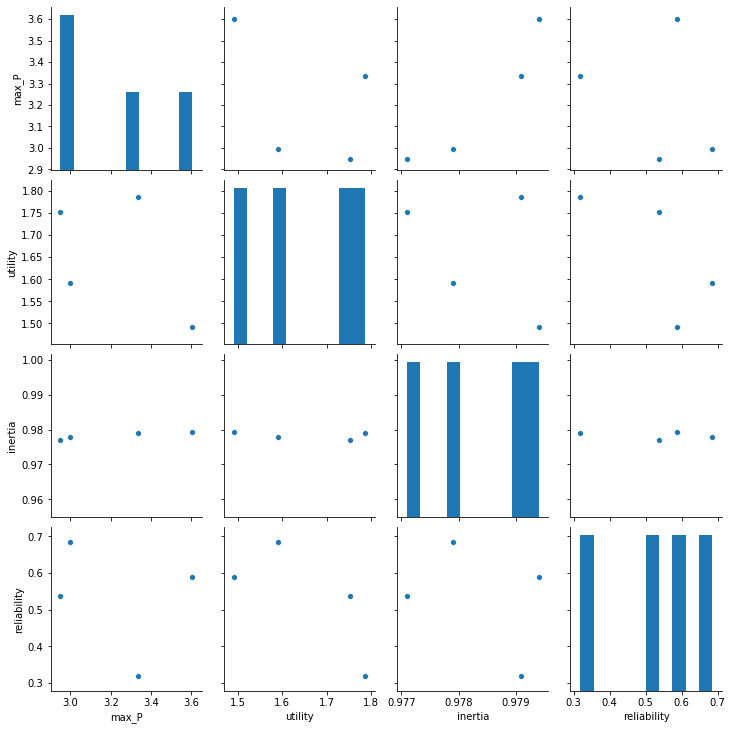

In [112]:
if __name__ == "__main__":
    outcomes = pd.DataFrame(outcomes)
    outcomes_filtered = outcomes.loc[outcomes['max_P'] <= np.mean(outcomes['max_P'])].loc[
                                     outcomes['utility'] >= np.mean(outcomes['utility'])].loc[
                                     outcomes['inertia'] <= np.mean(outcomes['inertia'])].loc[
                                     outcomes['reliability'] >= np.mean(outcomes['reliability'])].reset_index().drop(columns=['index'])
    # Filter outcomes based on median values to get 'interesting cases'
    
    uniqueness = {}
    for i in range(outcomes_filtered.index.size):
        distance_to_mean = np.absolute(outcomes_filtered['utility'][i] - np.mean(outcomes['utility'])) * np.absolute(outcomes_filtered['max_P'][i] - np.mean(outcomes['max_P'])) * np.absolute(outcomes_filtered['inertia'][i] - np.mean(outcomes['inertia'])) * np.absolute(outcomes_filtered['reliability'][i] - np.mean(outcomes['reliability']))
        uniqueness[i] = distance_to_mean
    # Get the uniqueness as the product of the distance to the mean for all outcomes
    
    sorted_uniqueness = sorted(uniqueness.items(), key=lambda x: x[1], reverse = True)
    # The highest number of uniqueness represents difference to the average
    
    unique_policies = []
    for i in range(4):
        unique_policies.append(sorted_uniqueness[i][0])
    # The first four get added to our list of interesting cases
    outcomes_unique = outcomes_filtered.iloc[unique_policies]
    
    outcomes_plot = pd.concat([outcomes_filtered, outcomes_unique]).reset_index().drop(columns=['index'])
    #sns.pairplot(outcomes_plot)
    sns.pairplot(outcomes_unique)
    # Visualisation
    # Maar eigenlijk wil ik unique in dezelfde plot hebben als de "filtered" opties met een andere kleur om te laten zien dat we diverse scenarios hebben gekozen

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


,index,max_P,utility,inertia,reliability
0,0,7.152192,1.001065,0.9803,0.0300
1,1,3.203818,1.171201,0.9794,0.1100
2,2,6.486928,0.664219,0.9800,0.0600
3,3,22.279482,0.841910,0.9880,0.0384
4,4,2.535035,1.349494,0.9758,0.1856
...,...,...,...,...,...
2499,2499,3.461820,0.910861,0.9900,0.2623
2500,3,2.950815,1.752271,0.9771,0.5364
2501,12,2.996280,1.590704,0.9779,0.6841
2502,4,3.602195,1.490793,0.9794,0.5877


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?
